In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from autoemulate.compare import AutoEmulate
from sklearn.metrics import r2_score

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.flow_functions import FlowProblem

import json

show_progress = False if os.getenv("JUPYTER_BOOK_BUILD", "false").lower() == "true" else True

In [14]:
# Load the simulation input parameters and summary statistics

n_samples = 1024 ## compare with separate notebook 32768

sim_path = f'./outputs/simulations/output_{n_samples}_samples/'

# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(sim_path, f'input_samples_{n_samples}.csv'))

# Load the boolean mask for failed simulations
with open(os.path.join(sim_path, 'bool_indices.json'), 'r') as f:
    bool_indices = json.load(f)

# Load the summary statistics
summary_stats = pd.read_csv(os.path.join(sim_path, f'simulations_summary.csv'))


In [15]:
# Get column names for parameters up to 'T'
parameter_names = list(input_params.columns[:input_params.columns.get_loc('T') + 1])

input_params[parameter_names]

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas,T
0,324.140512,0.429410,970.557289,2.593650,5.759509,141.391649,5.535208,3.645771,0.302181,0.614511,13.751520,0.074688,1.310537,3.983934,10.192377,0.040153,458.957450
1,213.211374,0.168363,1134.582900,3.092750,11.457833,81.051107,6.337772,5.927350,0.476733,0.449234,6.030600,0.032403,0.538215,2.789425,7.998957,0.014420,1177.644680
2,128.027561,0.373035,664.791603,1.807716,9.775524,110.934879,3.831676,4.690519,0.657067,0.244713,9.303856,0.023797,1.070499,3.257826,7.055576,0.027896,771.390037
3,287.120769,0.262023,1448.888220,3.761496,8.444797,167.239972,7.529157,2.905174,0.338195,0.522401,10.791995,0.054236,0.830979,2.014983,14.871574,0.027224,590.140139
4,261.317508,0.322630,1342.111306,4.190009,7.184780,154.969280,3.238999,4.237066,0.583734,0.372392,7.797148,0.048891,1.195902,2.575591,12.781972,0.020054,650.410479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,261.336061,0.190403,1060.430090,3.829753,8.749393,176.012319,3.756595,2.227771,0.495854,0.503679,11.065154,0.046696,1.076971,4.118564,11.541501,0.018005,330.688644
1020,287.095404,0.429649,604.711194,4.168636,6.915890,163.868692,8.514125,4.979986,0.314714,0.401441,7.835940,0.055462,0.957671,3.554178,11.131568,0.011772,502.394623
1021,128.376105,0.168051,1509.243287,2.167978,10.214802,90.909231,3.211540,2.679141,0.463341,0.573754,11.990096,0.020748,1.201641,1.719522,8.315260,0.043070,1133.246159
1022,212.885174,0.373382,852.661328,3.429577,12.987453,116.740297,6.845566,3.868677,0.616176,0.539212,12.763343,0.033914,0.657632,4.250799,6.738963,0.021397,815.733629


In [16]:
# Drop all the rows from input_params that correspond to entries in bool_indices
input_params = input_params.drop(bool_indices)

In [17]:
Y = summary_stats['p_ao_mean'].values

In [18]:
em = AutoEmulate()
em.setup(X = input_params[parameter_names], 
         y = Y, 
         models = ['gp'], ## Stick to gp
         n_jobs=-8)

,Values
Simulation input shape (X),"(1020, 17)"
Simulation output shape (y),"(1020,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),False


In [19]:
best_model = em.compare()

Cross-validating:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,None,GaussianProcess,gp,1,44.669802,0.446001
1,None,GaussianProcess,gp,2,41.318534,0.417540
2,None,GaussianProcess,gp,3,47.886609,0.394989
3,None,GaussianProcess,gp,4,45.449120,0.363683
4,None,GaussianProcess,gp,0,43.601610,0.351100


In [21]:
gp = em.get_model("GaussianProcess")
em.evaluate(gp)
eval_df = em.evaluate(gp)

In [ ]:
# 2. Extract the R² value
r2 = eval_df['r2'].iloc[0]

# 3. Save R² value
import os
save_folder = "outputs/emulator_r2/r2_values"
os.makedirs(save_folder, exist_ok=True)
r2_path = os.path.join(save_folder, f"r2_{n_samples}.txt")
with open(r2_path, "w") as f:
    f.write(str(r2))
print(f"Saved R² value ({r2:.4f}) to {r2_path}")

Saved R² value (0.5522) to outputs/emulator_r2/r2_values/r2_1024.txt


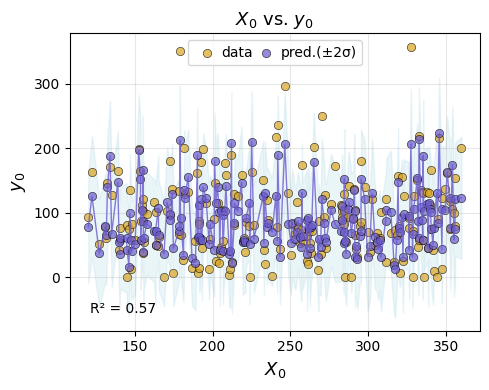

In [23]:
em.plot_eval(gp)

In [24]:
best_emulator = em.refit(gp)